In [29]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy
try:
    nlp = spacy.load('en_core_web_sm')
except:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

print("Done")

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Done


In [2]:
df = pd.read_csv("email.csv")

print(df.shape)

df.head()

(5573, 2)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.describe().T

,count,unique,top,freq
Category,5573,3,ham,4825
Message,5573,5158,"Sorry, I'll call later",30


In [5]:
df = df[df["Category"].isin(["ham", "spam"])]

print(df.shape)

df.head()

(5572, 2)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA

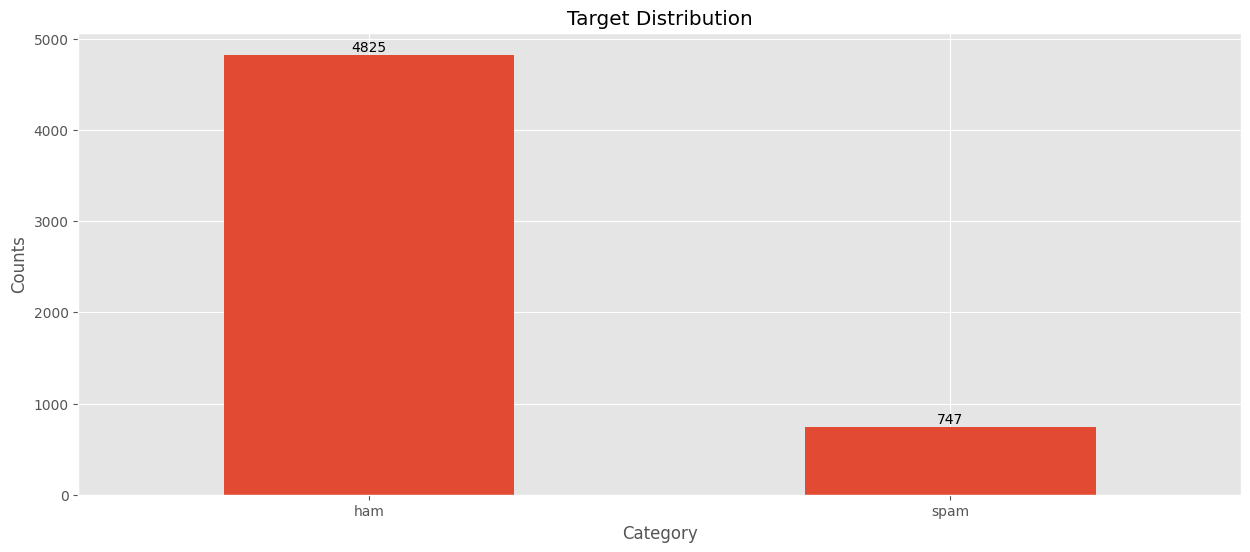

In [25]:
target_dist = df["Category"].value_counts().plot(kind="bar", 
                                                 figsize=(15, 6),
                                                 xlabel="Category",
                                                 ylabel="Counts",
                                                 title="Target Distribution")
for p in targte_dist.patches:
    h = p.get_height()
    target_dist.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")

target_dist.set_xticklabels(labels=target_dist.get_xticklabels(), rotation=0)
plt.show()

## Preprocess Dataset
* Remove Urls
* Remove non words
* Remove Digits
* Remove StopWords
* Lemmatize word (using spacy)

##### Note: The difference between stemming and lemmatization is that stemming reduces words to a base word that's not meaningful while lemmatization reduces words to a meaningful baseword. Also, stemming doesn't take time while lemmatization takes time.

In [6]:
def PreprocessText(sent:str):    
    remove_urls = re.sub(r"https?://\S+", " ", sent.lower())
    remove_non_words = re.sub(r'[^\w\s]', " ", remove_urls)
    remove_digits = re.sub(r'\d', " ", remove_non_words)
    remove_stopwrds = " ".join([i for i in word_tokenize(remove_digits) if i not in set(stopwords.words("english"))])
    lemmatize_word = " ".join([i.lemma_ for i in nlp(remove_stopwrds)]) 
    """
    The alternative for lemmatize_word:
    remove_stopwrds = [i for i in word_tokenize(remove_digits) if i not in set(stopwords.words("english"))]
    lemmatize_word = " ".join([nlp(i)[0].lemma_ for i in remove_stopwrds]) 
    """
    return lemmatize_word

In [7]:
df["PreprocessedText"] = df["Message"].apply(PreprocessText)

In [8]:
df.head()

,Category,Message,PreprocessedText
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live around though


## Text to Vector:
This can be done by:
* CountVectorizer (also known as bag of words)
* TfidfVectorizer (this gives importance to words with more occurence)

In [9]:
X_CountVec = CountVectorizer().fit_transform(df["PreprocessedText"]).toarray()
X_TfidfVec = TfidfVectorizer().fit_transform(df["PreprocessedText"]).toarray()

## Encode Target Column

In [13]:
encoder = LabelEncoder()

y_encode = encoder.fit_transform(df["Category"])

class_indices = {j:i for i, j in zip(encoder.classes_, range(len(encoder.classes_)))}

class_indices

{0: 'ham', 1: 'spam'}

## Train Test Split

In [16]:
x_ctrain, x_ctest, y_ctrain, y_ctest = train_test_split(X_CountVec, y_encode, test_size=.1, stratify=y_encode)
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(X_TfidfVec, y_encode, test_size=.1, stratify=y_encode)

print(x_ctrain.shape, y_ctrain.shape, x_ctest.shape, y_ctest.shape)

(5014, 6627) (5014,) (558, 6627) (558,)


## Modelling

In [44]:
def plot_roc_curve(y_true, y_pred_prob, ax):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    # Plotting the ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")

def TrainAndEvaluateAlgorithm(X, y, X_val, y_val, algo):
    algo.fit(X, y)
    train_pred = algo.predict(X)
    val_pred = algo.predict(X_val)

    fig, ax = plt.subplots(2,2,figsize=(13, 7))
    
    print("Training Classification report:\n\n", metrics.classification_report(y, train_pred))

    # Training
    sns.heatmap(metrics.confusion_matrix(y, train_pred),
                annot=True, 
                xticklabels=["ham", "spam"], 
                yticklabels=["ham", "spam"],
                ax=ax[0, 0])
    
    ax[0, 0].set_title("Confusion Matrix")
    ax[0, 0].set_xlabel("Actual Label")
    ax[0, 0].set_ylabel("Predicted Label")

    plot_roc_curve(y, train_pred, ax[0, 1])

    # Validation
    print("Validation Classification report:\n\n", metrics.classification_report(y_val, val_pred))
    
    sns.heatmap(metrics.confusion_matrix(y_val, val_pred),
                annot=True, 
                xticklabels=["ham", "spam"], 
                yticklabels=["ham", "spam"],
                ax=ax[1, 0])
    
    ax[1, 0].set_title("Confusion Matrix")
    ax[1, 0].set_xlabel("Actual Label")
    ax[1, 0].set_ylabel("Predicted Label")

    plot_roc_curve(y_val, val_pred, ax[1, 1])

    plt.tight_layout()
    plt.show()

## RandomForestClassifier
* CountVectorizer
* TfidfVectorizer

Training Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4342
           1       1.00      1.00      1.00       672

    accuracy                           1.00      5014
   macro avg       1.00      1.00      1.00      5014
weighted avg       1.00      1.00      1.00      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.97      1.00      0.98       483
           1       1.00      0.79      0.88        75

    accuracy                           0.97       558
   macro avg       0.98      0.89      0.93       558
weighted avg       0.97      0.97      0.97       558



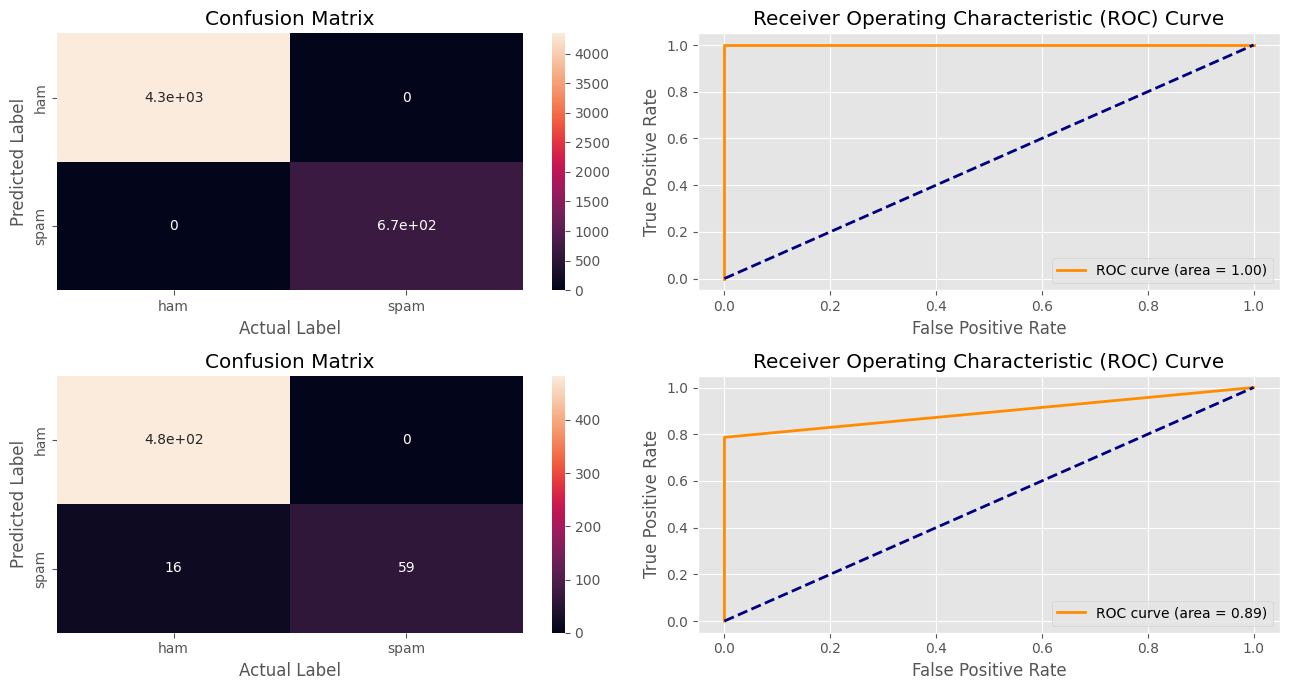

In [45]:
# CountVectorizer
TrainAndEvaluateAlgorithm(x_ctrain, y_ctrain, x_ctest, y_ctest, RandomForestClassifier())

Training Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4342
           1       1.00      1.00      1.00       672

    accuracy                           1.00      5014
   macro avg       1.00      1.00      1.00      5014
weighted avg       1.00      1.00      1.00      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.96      1.00      0.98       483
           1       1.00      0.76      0.86        75

    accuracy                           0.97       558
   macro avg       0.98      0.88      0.92       558
weighted avg       0.97      0.97      0.97       558



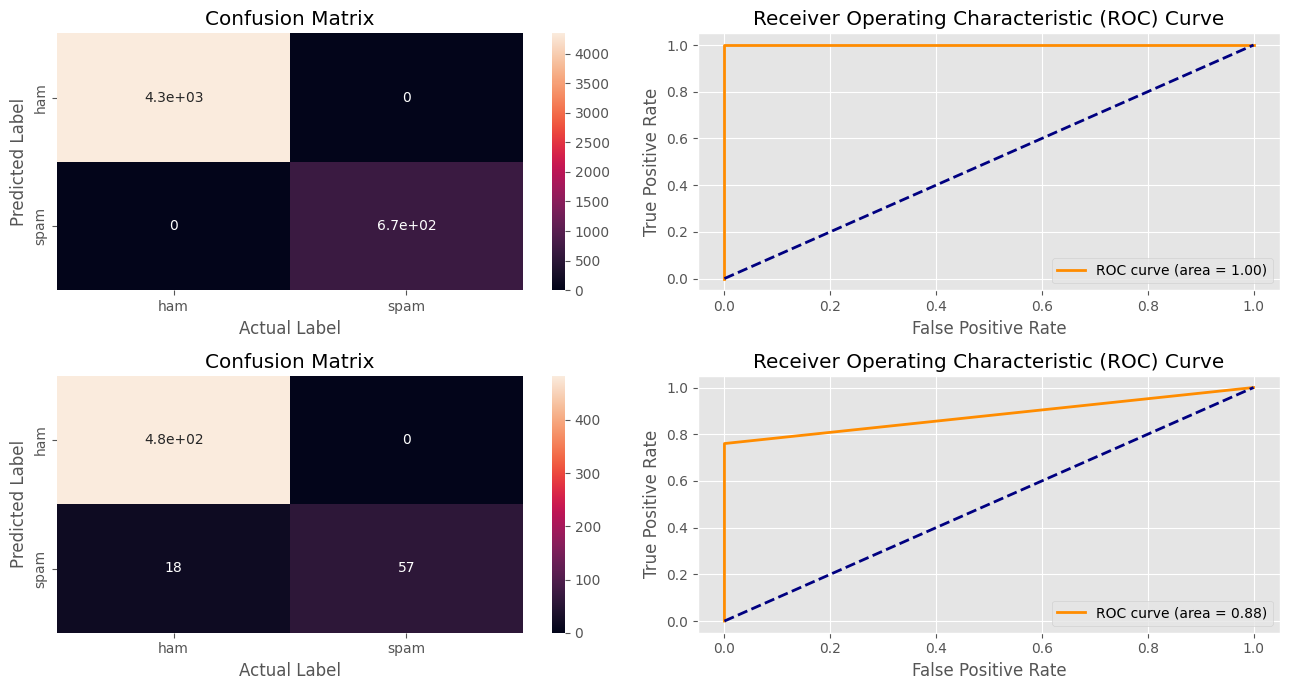

In [46]:
# TfidfVectorizer
TrainAndEvaluateAlgorithm(x_ttrain, y_ttrain, x_ttest, y_ttest, RandomForestClassifier())

## MultinomialNB
* CountVectorizer
* TfidfVectorizer

Training Classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4342
           1       0.97      0.97      0.97       672

    accuracy                           0.99      5014
   macro avg       0.98      0.98      0.98      5014
weighted avg       0.99      0.99      0.99      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       483
           1       0.92      0.95      0.93        75

    accuracy                           0.98       558
   macro avg       0.96      0.97      0.96       558
weighted avg       0.98      0.98      0.98       558



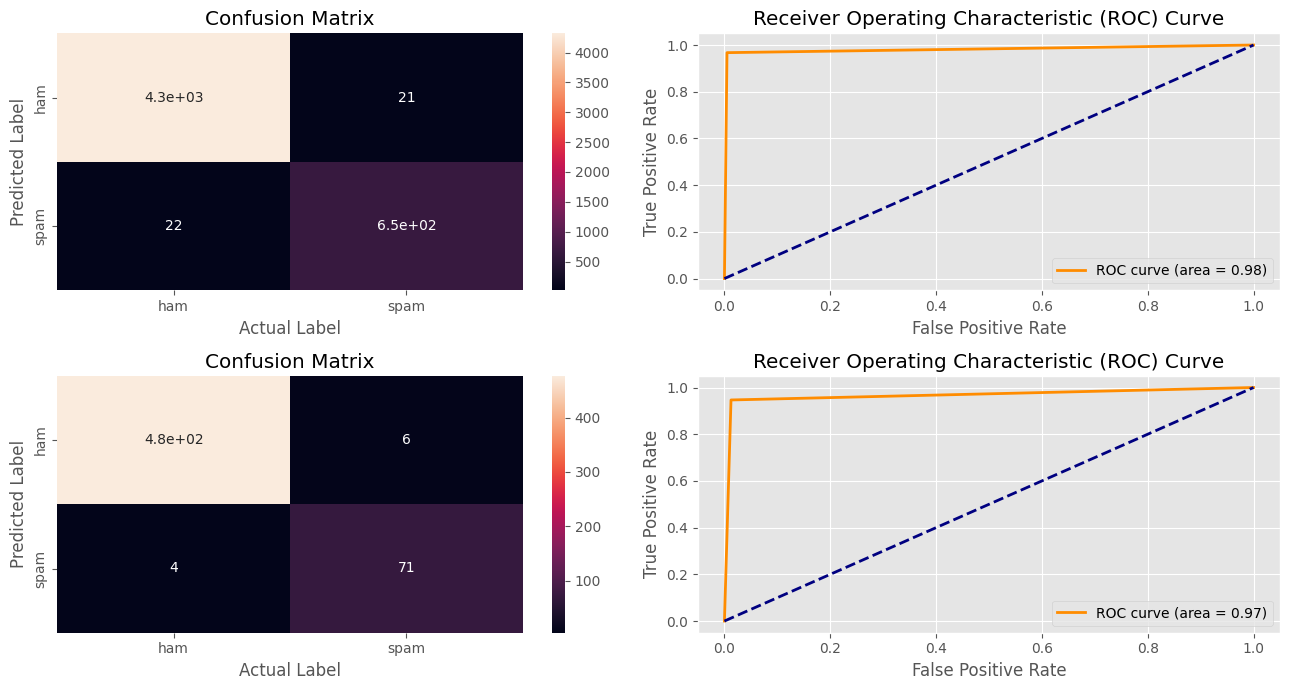

In [48]:
# CountVectorizer
TrainAndEvaluateAlgorithm(x_ctrain, y_ctrain, x_ctest, y_ctest, MultinomialNB())

Training Classification report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4342
           1       1.00      0.83      0.91       672

    accuracy                           0.98      5014
   macro avg       0.99      0.92      0.95      5014
weighted avg       0.98      0.98      0.98      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.95      1.00      0.98       483
           1       1.00      0.69      0.82        75

    accuracy                           0.96       558
   macro avg       0.98      0.85      0.90       558
weighted avg       0.96      0.96      0.96       558



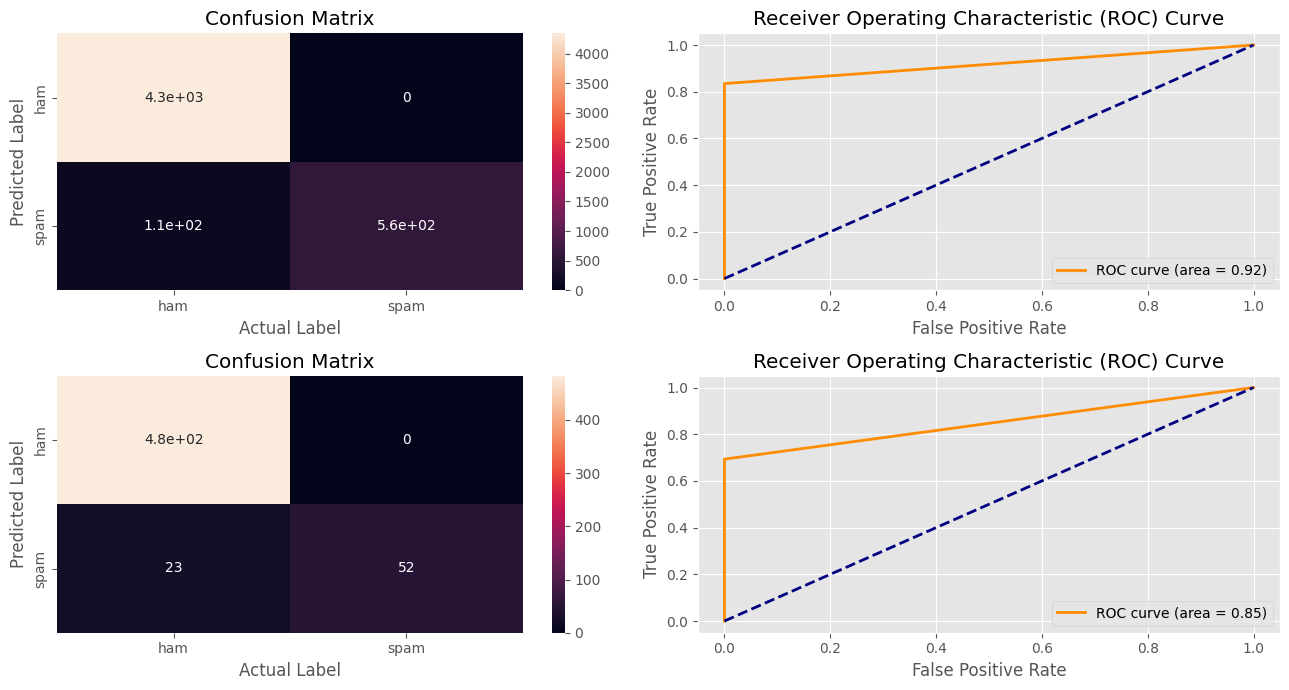

In [49]:
# TfidfVectorizer
TrainAndEvaluateAlgorithm(x_ttrain, y_ttrain, x_ttest, y_ttest, MultinomialNB())

## XGBClassifier
* CountVectorizer
* TfidfVectorizer

Training Classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4342
           1       1.00      0.92      0.96       672

    accuracy                           0.99      5014
   macro avg       0.99      0.96      0.98      5014
weighted avg       0.99      0.99      0.99      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.97      1.00      0.99       483
           1       0.98      0.83      0.90        75

    accuracy                           0.97       558
   macro avg       0.98      0.91      0.94       558
weighted avg       0.98      0.97      0.97       558



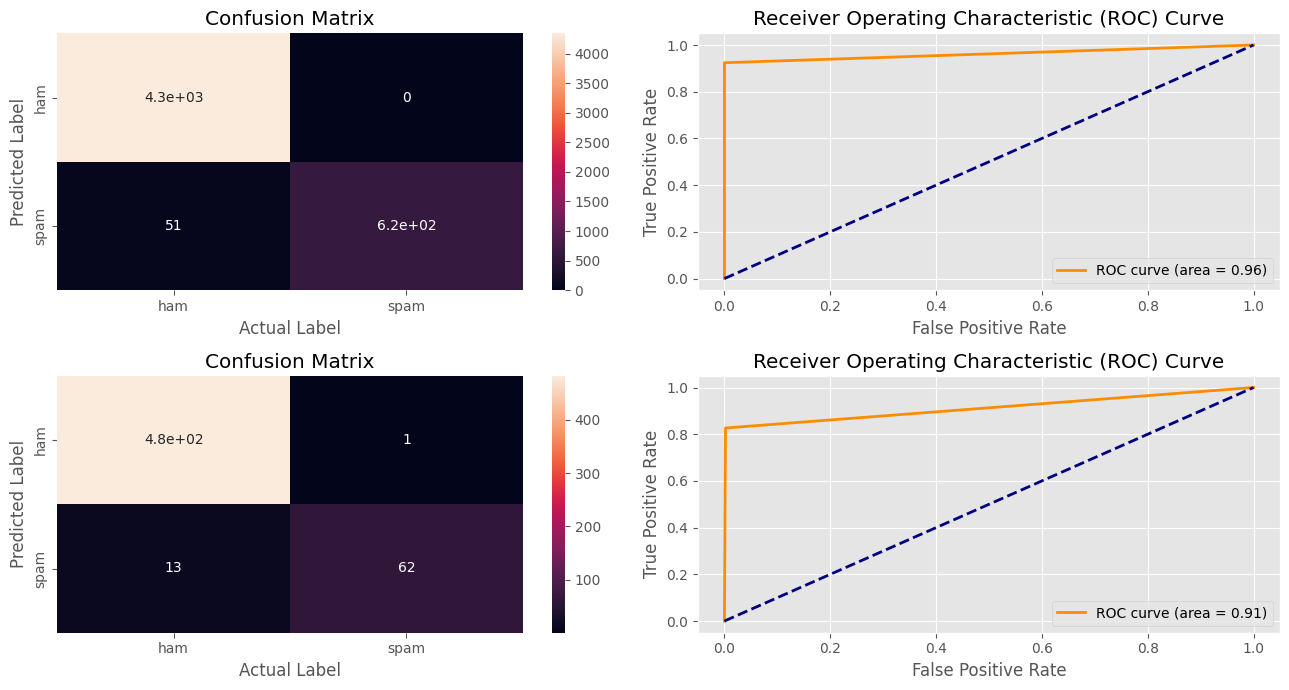

In [50]:
# CountVectorizer
TrainAndEvaluateAlgorithm(x_ctrain, y_ctrain, x_ctest, y_ctest, XGBClassifier())

Training Classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4342
           1       1.00      0.94      0.97       672

    accuracy                           0.99      5014
   macro avg       0.99      0.97      0.98      5014
weighted avg       0.99      0.99      0.99      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.97      1.00      0.98       483
           1       0.98      0.79      0.87        75

    accuracy                           0.97       558
   macro avg       0.98      0.89      0.93       558
weighted avg       0.97      0.97      0.97       558



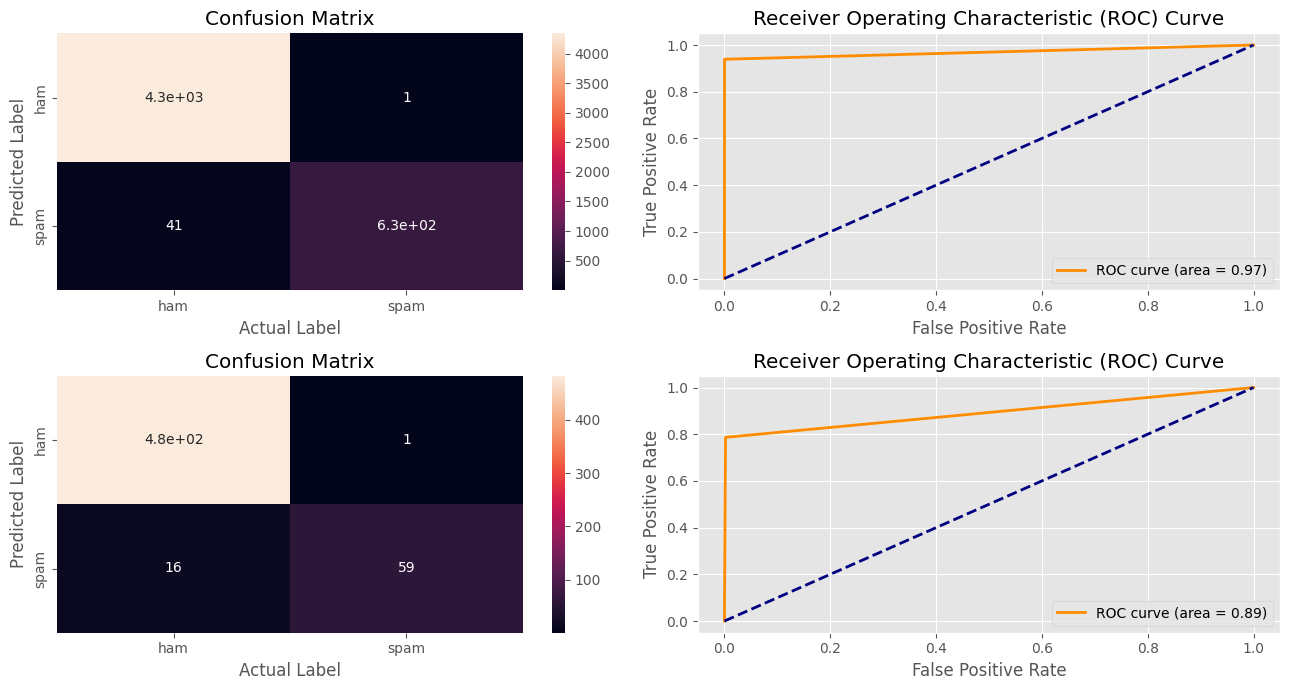

In [51]:
# TfidfVectorizer
TrainAndEvaluateAlgorithm(x_ttrain, y_ttrain, x_ttest, y_ttest, XGBClassifier())

## LGBMClassifier
* CountVectorizer
* TfidfVectorizer

Training Classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4342
           1       1.00      0.97      0.98       672

    accuracy                           1.00      5014
   macro avg       1.00      0.98      0.99      5014
weighted avg       1.00      1.00      1.00      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       483
           1       0.98      0.87      0.92        75

    accuracy                           0.98       558
   macro avg       0.98      0.93      0.96       558
weighted avg       0.98      0.98      0.98       558



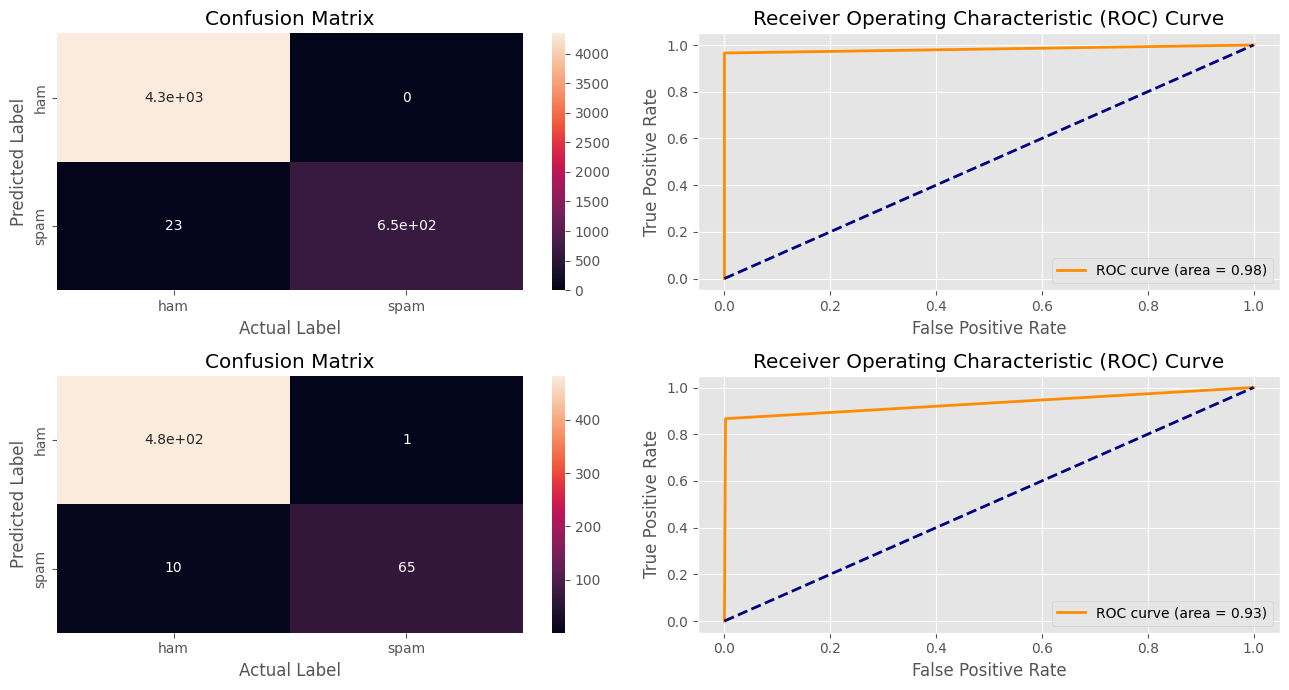

In [53]:
# CountVectorizer
TrainAndEvaluateAlgorithm(x_ctrain, y_ctrain, x_ctest, y_ctest, LGBMClassifier(verbose=0))

Training Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4342
           1       1.00      0.98      0.99       672

    accuracy                           1.00      5014
   macro avg       1.00      0.99      1.00      5014
weighted avg       1.00      1.00      1.00      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.98       483
           1       0.94      0.84      0.89        75

    accuracy                           0.97       558
   macro avg       0.96      0.92      0.94       558
weighted avg       0.97      0.97      0.97       558



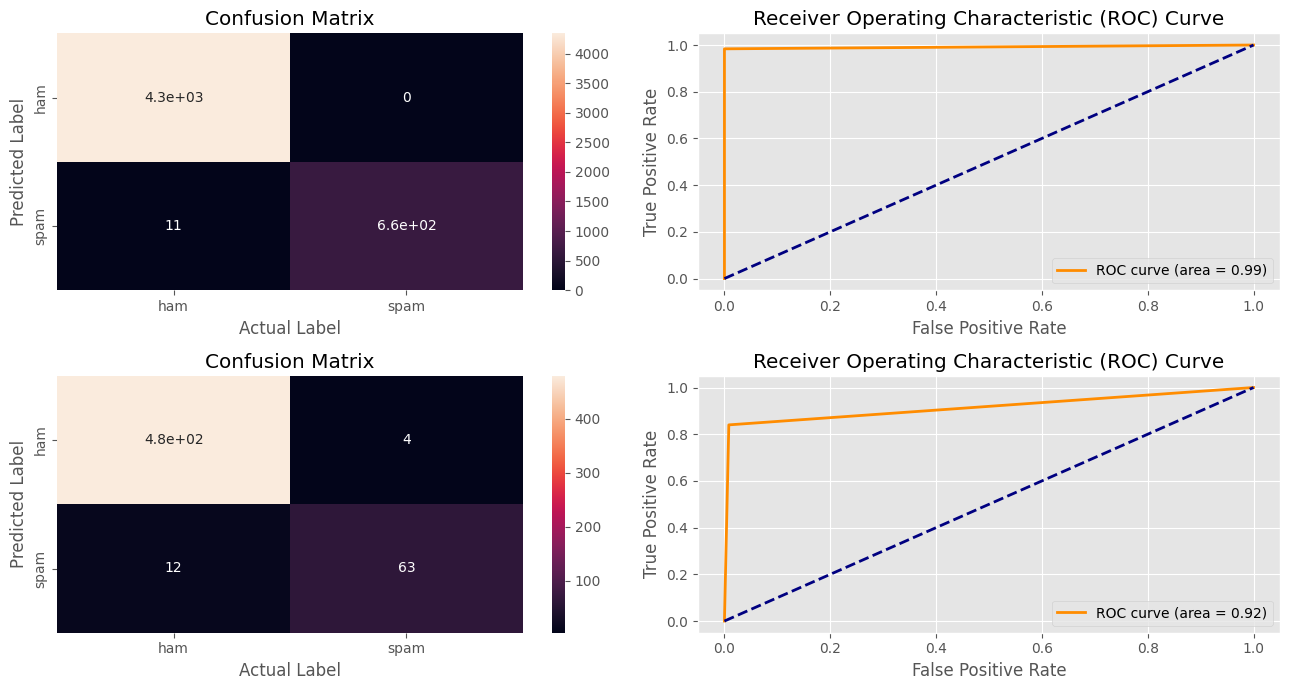

In [54]:
# TfidfVectorizer
TrainAndEvaluateAlgorithm(x_ttrain, y_ttrain, x_ttest, y_ttest, LGBMClassifier(verbose=0))

## CatBoostClassifier
* CountVectorizer
* TfidfVectorizer

Training Classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4342
           1       1.00      0.95      0.97       672

    accuracy                           0.99      5014
   macro avg       1.00      0.97      0.99      5014
weighted avg       0.99      0.99      0.99      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.97      1.00      0.98       483
           1       0.98      0.79      0.87        75

    accuracy                           0.97       558
   macro avg       0.98      0.89      0.93       558
weighted avg       0.97      0.97      0.97       558



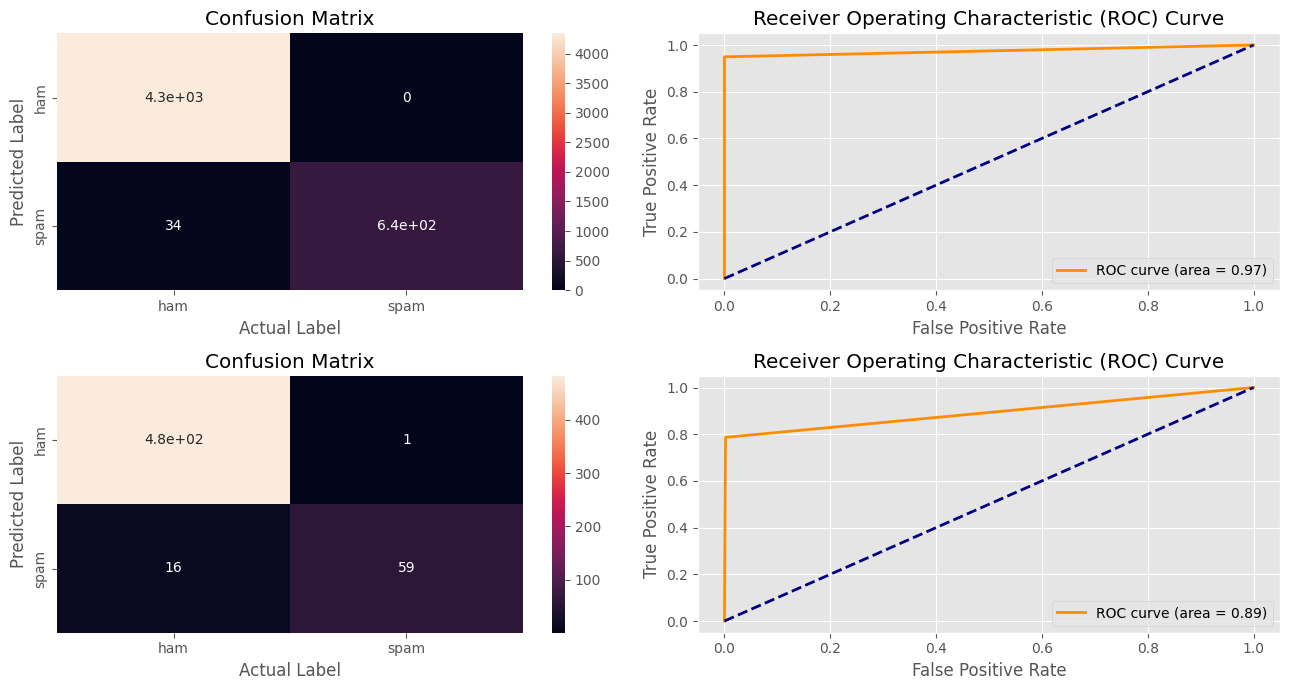

In [55]:
# CountVectorizer
TrainAndEvaluateAlgorithm(x_ctrain, y_ctrain, x_ctest, y_ctest, CatBoostClassifier(verbose=0))

Training Classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4342
           1       1.00      0.93      0.96       672

    accuracy                           0.99      5014
   macro avg       0.99      0.96      0.98      5014
weighted avg       0.99      0.99      0.99      5014

Validation Classification report:

               precision    recall  f1-score   support

           0       0.97      1.00      0.98       483
           1       0.98      0.79      0.87        75

    accuracy                           0.97       558
   macro avg       0.98      0.89      0.93       558
weighted avg       0.97      0.97      0.97       558



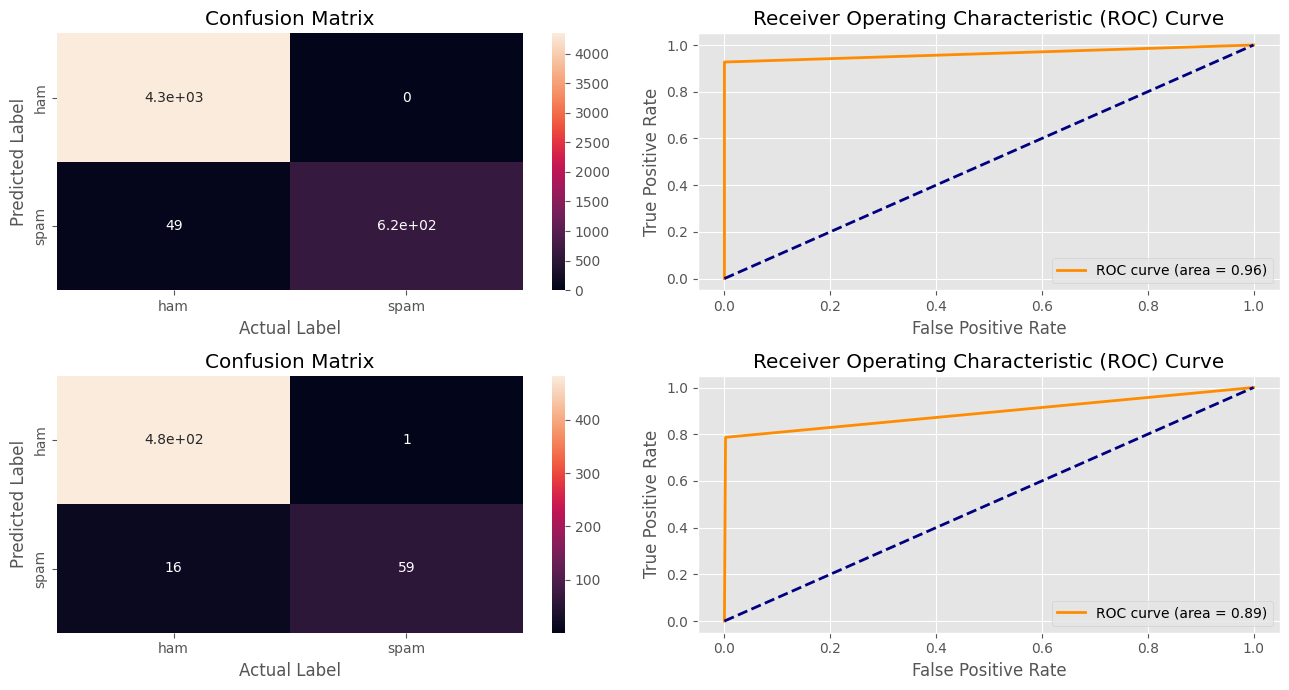

In [56]:
# TfidfVectorizer
TrainAndEvaluateAlgorithm(x_ttrain, y_ttrain, x_ttest, y_ttest, CatBoostClassifier(verbose=0))

# Eddy